In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Index
df = pd.read_csv('apple_stock_data.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Choose feature to predict
series = df[['close']].values # (N, 1)

# Scale to 0-1
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

In [2]:
# turn 1D series to supervised sequences

def make_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window]) #next-day Close
    return np.array(X), np.array(y)

WINDOW = 10 # 10 days of history
X, y = make_sequences(series_scaled, WINDOW)

In [3]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential(
    [
        LSTM(50, input_shape=(WINDOW, 1), return_sequences=True),
        Dropout(0.2),
        Dense(1) # Predict one value: next close
    ]
)

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)


Epoch 1/50
32/32 - 5s - loss: 0.0510 - val_loss: 0.0948 - 5s/epoch - 141ms/step
Epoch 2/50
32/32 - 0s - loss: 0.0194 - val_loss: 0.0674 - 304ms/epoch - 9ms/step
Epoch 3/50
32/32 - 0s - loss: 0.0133 - val_loss: 0.0521 - 307ms/epoch - 10ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0104 - val_loss: 0.0419 - 306ms/epoch - 10ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0087 - val_loss: 0.0342 - 313ms/epoch - 10ms/step
Epoch 6/50
32/32 - 0s - loss: 0.0072 - val_loss: 0.0286 - 309ms/epoch - 10ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0060 - val_loss: 0.0241 - 321ms/epoch - 10ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0052 - val_loss: 0.0210 - 310ms/epoch - 10ms/step
Epoch 9/50
32/32 - 0s - loss: 0.0045 - val_loss: 0.0180 - 309ms/epoch - 10ms/step
Epoch 10/50
32/32 - 0s - loss: 0.0040 - val_loss: 0.0158 - 403ms/epoch - 13ms/step
Epoch 11/50
32/32 - 0s - loss: 0.0036 - val_loss: 0.0141 - 309ms/epoch - 10ms/step
Epoch 12/50
32/32 - 0s - loss: 0.0033 - val_loss: 0.0131 - 305ms/epoch - 10ms/step
Epoch 13/50
32/3

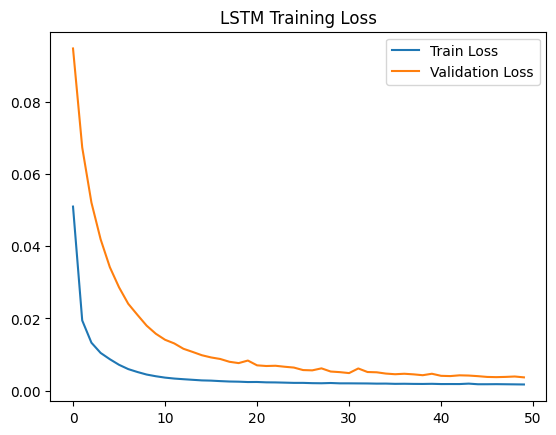

8/8 [==============================] - 0s 4ms/step


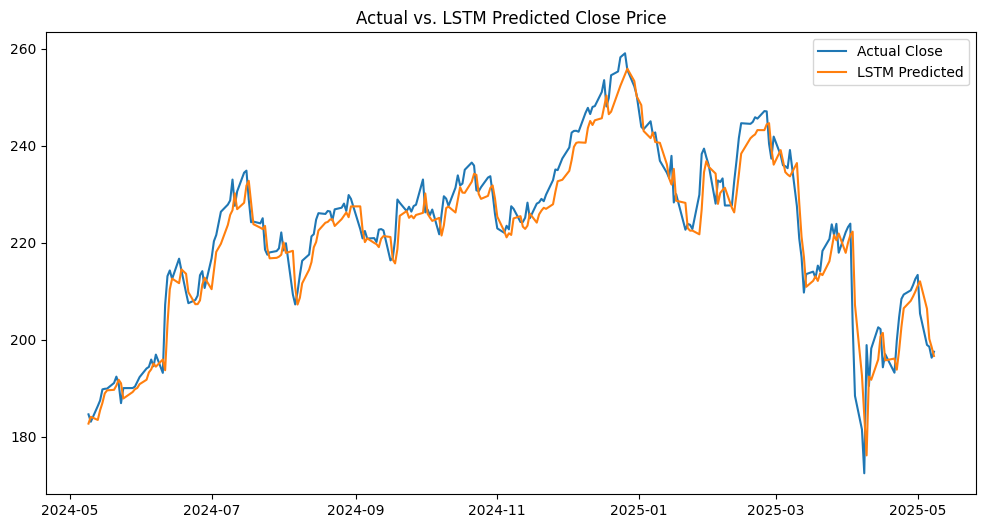

In [7]:
# Evaluate

# Plot train vs val loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()

# Predict & invert scale
y_pred_scaled = model.predict(X_test)
# If y_pred_scaled has shape (num_samples, window, 1), take only the last time step
if y_pred_scaled.ndim == 3:
	y_pred_scaled = y_pred_scaled[:, -1, 0]
elif y_pred_scaled.ndim == 2:
	y_pred_scaled = y_pred_scaled[:, -1]
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# Plot actual vs. predicted
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_true, label='Actual Close')
plt.plot(df.index[-len(y_test):], y_pred, label='LSTM Predicted')
plt.legend()
plt.title("Actual vs. LSTM Predicted Close Price")
plt.show()